# Shockley-Queisser Limit Calculator
Or more accurately the _detailed balance limit_ calculator

Based on the Mathematica script by Steve Byrnes. Original pdf explaning the script available here: http://sjbyrnes.com/sq.pdf, do check it out, if only for the correct pronunciation of 'Queisser'. 

From Steve's document:

> The Schockley-Queisser (SQ) limit is a famous limit on the maximal possible efficiency of solar cells, limited only by fundamental physics. It applies to most solar cell designs in the world, except for "tandem solar cells" and some additional obscure exceptions (discussed at the end of the document) [Check out the original pdf for this info]. The most important parameter in the SQ model is the bandgap of the semiconductor: If the gap is right, the efficiency can be up to 34%, if the gap is way off, the efficiency limit may be much smaller.

The efficiency predicted by the SQ limit **applies only to the solar spectrum**. This notebook first recreates the SQ limit calculation to verify the method, and then applies it to some artificial light sources. 

In [285]:
import numpy as np
import scipy.constants as constants
import matplotlib.pyplot as plt
import matplotlib
import os

font = {'size' : 22}

matplotlib.rc('font',**font)

In [2]:
%matplotlib inline

In [3]:
# Loading data from text files
# You may have to modify the next line if running the notebook locally
module_dir = os.path.dirname(os.path.abspath('.\\Jupyter\\')) + os.sep

# the ASTMG173.csv file holds the standard AM1.5 solar spectrum
# You can find the original at rredc.nrel.gov/solar/spectra/am1.5
spectrum = np.loadtxt(module_dir + '\\Spectra\\'+ 'ASTMG173.csv', delimiter=',', skiprows=1)

In [4]:
# Just some constants for the upcoming math
c = constants.value('speed of light in vacuum')
h = constants.value('Planck constant in eV s')
e = constants.value('elementary charge')
k = constants.value('Boltzmann constant in eV/K')

pi = 3.1415

# Globals
Tcell = 300  # Kelvin
# Energy Gap
# The energy gap enetered here will be highlighted on upcoming plots. 
# Default is set to silicon bandgap 1.1eV
Egap = 1.1  #electron volts
egap = 1.1  #electron volts
# Silicon = 1.1eV

In [271]:
##Why are numbers not correct?

#working but off by a factor of 4??

#can't figure things out exactly with the factors but get the correct result setting the solid angle to pi. see the one note notebook.

r_earth = 6e6
r_sun = 6.95e8
d_sun = 1.50e11

def stephan(T):
    result = (5.670367e-8)*(T**4)
    
    #units W/m^2
    return result

def solid_angle (r_e, d_sun):
    return 4*(pi)*((pi*r_e**2)/(4*pi*d_sun**2))

def gen_emissivity(e_low,e_high,E_cutoff,E_bb):
    emissivity = np.copy(E_bb)
    
    i=0
    for E in E_bb:
        if (E<E_cutoff):
            emissivity[i] = e_low
        else: 
            emissivity[i] = e_high
        i=i+1    
    
    return emissivity

def lor_emissivity(e_bg,e_high,E_cutoff,w,E_bb):
    emissivity = np.copy(E_bb)
    
    i=0
    for E in E_bb:
        emissivity[i] = e_bg + (e_high-e_bg)/(1 + ((E-E_cutoff)**2/(w**2))  )
        i=i+1   
    return emissivity

def spect_rad(T,E_bb, emissivity, powfactor = 1):
    
    a = (2*(E_bb**3))/(h**3*c**2)
    b = 1/( np.exp((E_bb)/(k*T)) -1 )
    intensity = a*b*powfactor
    
    intensity = intensity*emissivity
    
    #intensity = -intensity/np.trapz(intensity,E_bb)
    

            
    
    
    # units (eV/s)/m^2*eV*sr
    
    intensity = intensity*e 
    
     # units W/m^2*eV*sr
    
    spectra = np.transpose(np.stack((E_bb,intensity)))
    return spectra

def rad_to_power(spectrum, solidangle = solid_angle(r_earth,d_sun),emitterarea = 4*pi*r_sun**2):

    spectra =  spectrum[:,1]
    spectra = spectra*solidangle/4   ### fudge factor of 4 for now. see above.
    spectra = spectra*emitterarea   
    spectrum[:,1] = spectra
    
    # units W/eV
    
    return spectrum

# convert to photons from energy
def power_to_photons(spectrum):
    converted = np.copy(spectrum)
    converted[:, 1] = converted[:, 1]/converted[:,0] * 1/e
    
    # units #/eV
    
    return converted

def solar(T,E_bb,emissivity):
    BB = spect_rad(T,E_bb,emissivity)
    BB = rad_to_power(BB)
    BB[:,1] = BB[:,1]/(pi*r_earth**2)
    # units W/eV
    
    return BB



In [282]:
E_min = 0.3
E_max = 10
E_step = 0.01 
E_bb = np.arange(E_min, E_max,E_step) 
E_bb = np.flip(E_bb,0)

#emissivity =gen_emissivity(0.1,1,1.1,E_bb)

emissivity =lor_emissivity(0.1,1,1.25,0.1,E_bb)

BB_5500K = solar(5750,E_bb,emissivity)

BB_2500K = solar(2550,E_bb,emissivity)

BB_5500K_ph = power_to_photons(BB_5500K)

#check integrated irradiance is ~1kW/m^2
integrate = -np.trapz(BB_5500K[:,1],BB_5500K[:,0] )
print(integrate)

print(stephan(5750)*4*pi*r_sun**2)

280.6958300171312
3.762263521545546e+26


C:\Users\aspit\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


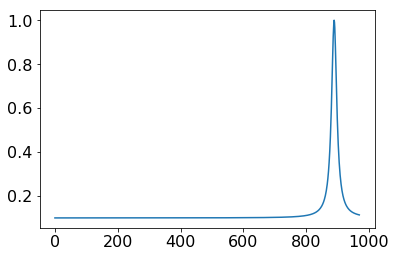

In [273]:
plt.plot(emissivity)

Text(0.5,1,'Spectral Irradiance')

C:\Users\aspit\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


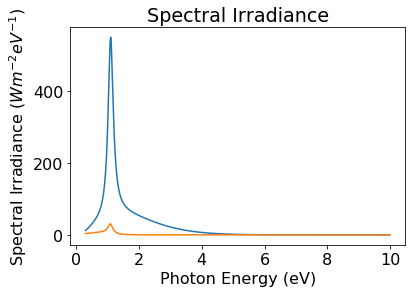

In [274]:
plt.plot(BB_5500K[:,0],BB_5500K[:,1])
plt.plot(BB_2500K[:,0],BB_2500K[:,1])
plt.xlabel('Photon Energy (eV)')
plt.ylabel('Spectral Irradiance ($Wm^{-2}eV^{-1}$)')
plt.title('Spectral Irradiance')

Text(0.5,1,'Spectrum Irradiance')

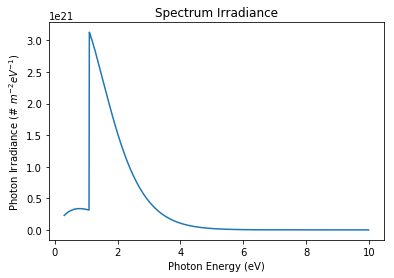

In [166]:
plt.plot(BB_5500K_ph[:,0],BB_5500K_ph[:,1] )
plt.xlabel('Photon Energy (eV)')
plt.ylabel('Photon Irradiance (# $m^{-2}eV^{-1}$)')
plt.title('Spectrum Irradiance')

In [40]:
def photons_above_bandgap(egap, spectrum):
    """Counts number of photons above given bandgap"""
    indexes = np.where(spectrum[:, 0] > egap)
    y = spectrum[indexes, 1][0]
    x = spectrum[indexes, 0][0]
    return np.trapz(y[::-1], x[::-1])


def photons_above_bandgap_plot(spectrum):
    """Plot of photons above bandgap as a function of bandgap"""
    a = np.copy(spectrum)
    for row in a:
        # print row
        row[1] = photons_above_bandgap(row[0], spectrum)
    plt.plot(a[:, 0], a[:, 1])

    p_above_1_1 = photons_above_bandgap(Egap, spectrum)
    plt.plot([Egap], [p_above_1_1], 'ro')
    plt.text(Egap+0.05, p_above_1_1, '{}eV, {:.4}'.format(Egap, p_above_1_1))

    plt.xlabel('$E_{gap}$ (eV)')
    plt.ylabel('# Photons $m^{-2}s^{-1}$')
    plt.title('Number of above-bandgap \nphotons as a function of bandgap')
    plt.show()

In [165]:
#photons_above_bandgap_plot(BB_5500K_ph)

In [42]:
def rr0(egap, spectrum):

    const = (2 * np.pi) / (c**2 * h**3)

    E = spectrum[::-1, ]  # in increasing order of bandgap energy
    egap_index = np.where(E[:, 0] >= egap)
    numerator = E[:, 0]**2
    exponential_in = E[:, 0] / (k * Tcell)
    denominator = np.exp(exponential_in) - 1
    integrand = numerator / denominator

    integral = np.trapz(integrand[egap_index], E[egap_index, 0])

    result = const * integral
    return result[0]

In [43]:
def recomb_rate(egap, spectrum, voltage):
    print( 'recomb rate')
    return e * rr0(egap, spectrum) * np.exp(voltage / (k * Tcell))

In [94]:
def current_density(egap, spectrum, voltage):
    # print 'current_density'
    # print photons_above_bandgap(egap, spectrum), 'photons above bandgap'
    # print e * (photons_above_bandgap(egap, spectrum) - rr0(egap, spectrum)), 'photons above bandgap - rr0'
    return e * (photons_above_bandgap(egap, spectrum) - rr0(egap, spectrum) * np.exp(voltage / (k * Tcell)) -1)


def jsc(egap, spectrum):
    # print 'jsc'
    return current_density(egap, spectrum, 0)


def voc(egap, spectrum):
    # print 'voc'
    return (k * Tcell) * np.log(photons_above_bandgap(egap, spectrum) / rr0(egap, spectrum))

In [95]:
# For an ideal solar cell these will be
print('A material with a bandgap of %.2f will have an:' % Egap)
print('Ideal short circuit current: ', jsc(1.1, BB_5500K_ph), 'A/m^2')
print('Ideal open circuit  voltage: ', voc(1.1, BB_5500K_ph), 'V')

A material with a bandgap of 1.10 will have an:
Ideal short circuit current:  85.74760638328827 A/m^2
Ideal open circuit  voltage:  0.8150721386139764 V


In [96]:
def ideal_jsc_plot(spectrum):
    """Plot of photons above bandgap as a function of bandgap"""
    a = np.copy(spectrum)
    for row in a:
        # print row
        row[1] = jsc(row[0], spectrum)
    plt.plot(a[:, 0], a[:, 1])
    e_gap = 1.1
    p_above_1_1 = jsc(e_gap, spectrum)
    plt.plot([e_gap], [p_above_1_1], 'ro')
    plt.text(e_gap+0.05, p_above_1_1, '{}eV, {:.4}'.format(e_gap, p_above_1_1))

    plt.xlabel('$E_{gap}$ (eV)')
    plt.ylabel('$J_{SC}$ $Am^{-2}$')
    plt.title('Ideal short-circuit current')


def ideal_voc_plot(spectrum):
    """Plot of the ideal open circuit voltage as a function of bandgap"""
    a = np.copy(spectrum)
    for row in a[2:]:
        # print row
        row[1] = voc(row[0], spectrum)
    plt.plot(a[:, 0], a[:, 1])
    plt.plot(a[:, 0], a[:, 0])
    e_gap = 1.1
    p_above_1_1 = voc(e_gap, spectrum)
    plt.plot([e_gap], [p_above_1_1], 'ro')
    plt.text(e_gap+0.05, p_above_1_1, '{}eV, {:.4}'.format(e_gap, p_above_1_1))

    plt.xlabel('$E_{gap}$ (eV)')
    plt.ylabel('$V_{OC}$ (V)')
    plt.xlim((0.5,3.5))
    plt.ylim((0,3.5))
    plt.title('Ideal open-circuit voltage. Straight line is bandgap.')

In [164]:
#ideal_jsc_plot(BB_5500K_ph)

In [163]:
#ideal_voc_plot(BB_5500K_ph)

In [168]:
def iv_curve_plot(egap, spectrum, power=False):
    """Plots the ideal IV curve, or the ideal power for a given material"""
    v_open = voc(egap, spectrum)
    v = np.linspace(0, v_open)
    if power:
        p =  v * current_density(egap, spectrum, v)
        plt.xlabel('Voltage (V)')
        plt.ylabel('Power generated ($W$)')
        plt.title('Power Curve')
        plt.plot(v, p)
    else:
        i =  current_density(egap, spectrum, v)
        plt.xlabel('Voltage (V)')
        plt.ylabel('Current density $J$ ($Am^{-2}$)')
        plt.title('IV Curve')
        plt.plot(v, i)
    
#iv_curve_plot(Egap, BB_5500K_ph)

In [169]:
def iv_curve_plot(egap, spectrum, power=False):
    """Plots the ideal IV curve, and the ideal power for a given material"""
    v_open = voc(egap, spectrum)
    v = np.linspace(0, v_open)

    fig, ax1 = plt.subplots()
    p =  v * current_density(egap, spectrum, v)
    i =  current_density(egap, spectrum, v)
    
    ax1.plot(v, i)
    ax1.set_xlabel('Voltage (V)')
    ax1.set_ylabel('Current density $J$ ($Am^{-2}$)')
    ax1.legend(['Current'], loc=2)
    
    ax2 = ax1.twinx()
    ax2.plot(v, p, color='orange')
    ax2.set_ylabel('Power generated ($W$)')
    ax2.legend(['Power'], loc=3)
    return


#iv_curve_plot(Egap, BB_5500K_ph)

In [101]:
def v_at_mpp(egap, spectrum):
    v_open = voc(egap, spectrum)
    # print v_open
    v = np.linspace(0, v_open)
    index = np.where(v * current_density(egap, spectrum, v)==max(v * current_density(egap, spectrum, v)))
    return v[index][0]


def j_at_mpp(egap, spectrum):
    return max_power(egap, spectrum) / v_at_mpp(egap, spectrum)


def max_power(egap, spectrum):
    v_open = voc(egap, spectrum)
    # print v_open
    v = np.linspace(0, v_open)
    index = np.where(v * current_density(egap, spectrum, v)==max(v * current_density(egap, spectrum, v)))
    return max(v * current_density(egap, spectrum, v))

def int_irr(egap, spectrum):
    irradiance =  np.trapz(spectrum[::-1, 1] * e * spectrum[::-1, 0], spectrum[::-1, 0])
    # print photons_above_bandgap(egap, spectrum) * e
    return irradiance


def max_eff(egap, spectrum):
    irradiance =  np.trapz(spectrum[::-1, 1] * e * spectrum[::-1, 0], spectrum[::-1, 0])
    # print photons_above_bandgap(egap, spectrum) * e
    return max_power(egap, spectrum) / irradiance

In [75]:
print('For a cell with bandgap %.2f eV' % Egap)
print('max power %.2f' % max_power(Egap, BB_5500K_ph) )
print('Irradiance %.2f' % int_irr(Egap, BB_5500K_ph ))
print('Ideal efficiency is {:.4}%'.format(max_eff(Egap, BB_5500K_ph)*100))

For a cell with bandgap 1.10 eV
max power 11.68
Irradiance 28.38
Ideal efficiency is 41.16%


C:\Users\aspit\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


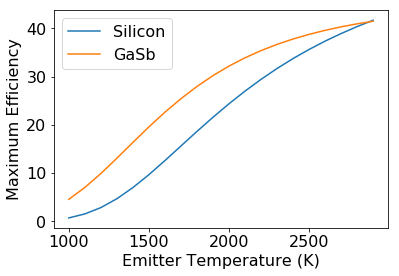

In [283]:
#generate multiple blackbody spectra

import pandas as pd

def max_eff_temp(Tmin,Tmax,dT,sourcetype = 1):
    # sourcetype 1 for sun and 0 for full angle

    Temps = pd.Series(np.arange(Tmin,Tmax,dT))

    spectra_ph_all = pd.Series(index = Temps,dtype=object)

    max_eff_all_Si = pd.Series(index = Temps)

    max_eff_all_GaSb = pd.Series(index = Temps)

    max_pow_all_Si = pd.Series(index = Temps)

    max_pow_all_GaSb = pd.Series(index = Temps)


    i=0
    for temp in Temps:
        if sourcetype:
            spectra = solar(temp,E_bb,emissivity)
        else:
            spectra = spect_rad(temp,E_bb,emissivity)
            spectra = rad_to_power(spectra, solidangle = 4*pi, emitterarea = 1)
        spectra_ph = power_to_photons(spectra)

        spectra_ph_all[temp] = spectra_ph
        max_eff_all_Si[temp] = max_eff(Egap, spectra_ph)*100
        max_eff_all_GaSb[temp] = max_eff(0.7, spectra_ph)*100

        max_pow_all_Si[temp] = max_power(Egap, spectra_ph)
        max_pow_all_GaSb[temp] = max_power(0.7, spectra_ph)
        i=i+1
    
    return max_eff_all_Si, max_eff_all_GaSb, max_pow_all_Si,max_pow_all_GaSb


max_eff_all_Si, max_eff_all_GaSb, max_pow_all_Si,max_pow_all_GaSb = max_eff_temp(1000,3000,100, 0)
#spectra_ph_all

ln1 = plt.plot(max_eff_all_Si)

ln2 = plt.plot(max_eff_all_GaSb)
lns = ln1 + ln2
plt.xlabel('Emitter Temperature (K)')
plt.ylabel('Maximum Efficiency')
plt.legend(lns, ('Silicon','GaSb'))
#plt.legend(max_eff_all_Si,'Si')

Text(0,0.5,'Emissivity')

C:\Users\aspit\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


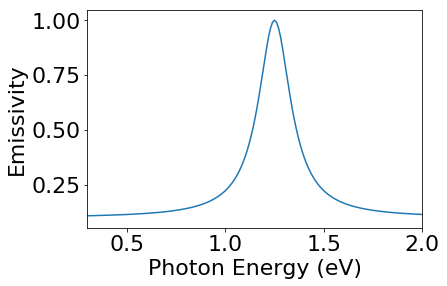

In [286]:
plt.plot(E_bb,emissivity)
plt.xlim((0.3,2))
plt.xlabel('Photon Energy (eV)')
plt.ylabel('Emissivity')

Text(0,0.5,'Maximum Power (W/m^2)')

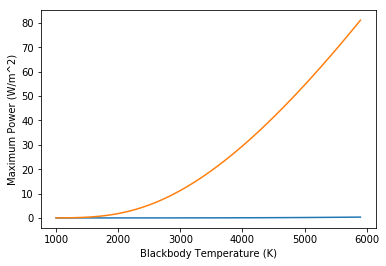

In [22]:
plt.plot(max_pow_all_Si)

plt.plot(max_pow_all_GaSb)
plt.xlabel('Blackbody Temperature (K)')
plt.ylabel('Maximum Power (W/m^2)')

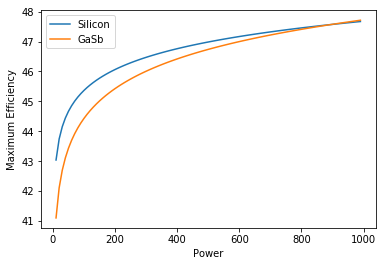

In [150]:
#generate multiple blackbody spectra now with the solid angle set to half 

import pandas as pd

powers = pd.Series(np.arange(10, 1000,10))

spectra_ph_all = pd.Series(index = powers,dtype=object)

max_eff_all_Si = pd.Series(index = powers)

max_eff_all_GaSb = pd.Series(index = powers)

max_pow_all_Si = pd.Series(index = powers)

max_pow_all_GaSb = pd.Series(index = powers)



i=0
for power in powers:
    spectra = spect_rad(5500, powfactor = power )
    spectra = rad_to_power(spectra, solidangle = 4*pi, emitterarea = 1)
    spectra_ph = power_to_photons(spectra)
    
    spectra_ph_all[power] = spectra_ph
    max_eff_all_Si[power] = max_eff(Egap, spectra_ph)*100
    max_eff_all_GaSb[power] = max_eff(0.7, spectra_ph)*100
    
    max_pow_all_Si[power] = max_power(Egap, spectra_ph)
    max_pow_all_GaSb[power] = max_power(0.7, spectra_ph)
    i=i+1
    
    
ln1 = plt.plot(max_eff_all_Si)

ln2 = plt.plot(max_eff_all_GaSb)
lns = ln1 + ln2
plt.xlabel('Power')
plt.ylabel('Maximum Efficiency')
plt.legend(lns, ('Silicon','GaSb'))

Text(0,0.5,'Maximum Power (W/m^2)')

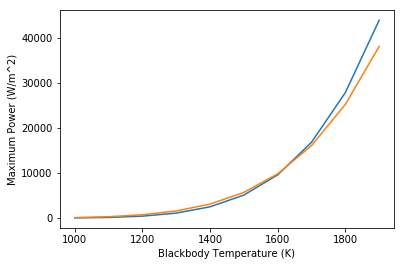

In [162]:
plt.plot(max_pow_all_Si)

plt.plot(max_pow_all_GaSb)
plt.xlabel('Blackbody Temperature (K)')
plt.ylabel('Maximum Power (W/m^2)')



In [25]:
print("Silicon cells")

print("efficiency " , max_eff_all_Si[2500])

print("power ", max_pow_all_Si[2500])
print("stephan ", stephan(2500))

print ("efficency from stephan" , max_pow_all_Si[2500]/stephan(2500)*100)

Silicon cells
efficiency  0.017917548434446037
power  272.2507506174327
stephan  2214987.109375
efficency from stephan 0.012291301807812927


In [26]:
print("GaSb cells")


print("efficiency " , max_eff_all_GaSb[2500])

print("power ", max_pow_all_GaSb[2500])
print("stephan ", stephan(2500))

print ("efficency from stephan" , max_pow_all_GaSb[2500]/stephan(2500)*100)

GaSb cells
efficiency  30.427904604643548
power  462341.14553328184
stephan  2214987.109375
efficency from stephan 20.87331089090356


To find the famous SQ limit curve, we need to maximise the ideal generated power over the bandgap energies. 

In [27]:
def sq_limit_plot(spectrum):
    # Plot the famous SQ limit
    a = np.copy(spectrum)
    # Not for whole array hack to remove divide by 0 errors
    for row in a[2:]:
        # print row
        row[1] = max_eff(row[0], spectrum)
    # Not plotting whole array becase some bad values happen
    plt.plot(a[2:, 0], a[2:, 1])
    e_gap = Egap
    p_above_1_1 = max_eff(e_gap, spectrum)
    plt.plot([e_gap], [p_above_1_1], 'ro')
    plt.text(e_gap+0.05, p_above_1_1, '{}eV, {:.4}'.format(e_gap, p_above_1_1))

    plt.xlabel('$E_{gap}$ (eV)')
    plt.ylabel('Max efficiency')
    plt.title('SQ Limit')

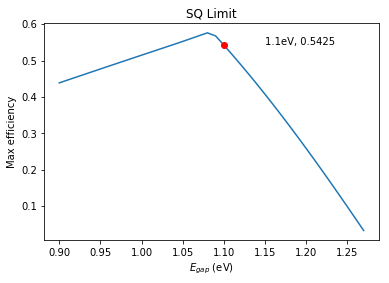

In [88]:
sq_limit_plot(BB_5500K_ph)

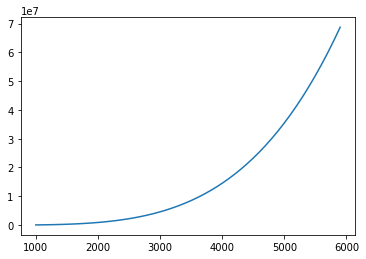

In [29]:
def stephan(T):
    result = (5.670367e-8)*(T**4)
    return result

Temp = np.arange(1000.0, 6000.0,100.0)
Rad = np.copy(Temp)

for i in range(len(Temp)):
    Rad[i] = stephan(Temp[i])

plt.plot(Temp,Rad)

In [30]:
b = 2.8977685e-3

T = b/1000

print(T)

2.8977685e-06
